# Importing Libraries and getting url

In [107]:
!pip install graphviz
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score 
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pandas as pd 
import numpy as np
%matplotlib inline
url='http://strainapi.evanbusse.com/80Bxz5h/strains/search/all'
response=requests.get(url)

In [82]:
dat=response.json()

## Creating Effects & Types DataFrame

In [4]:
names=list(dat.keys())
positive=[]
negative=[]
medical=[]
posi=[]
neg=[]
med=[]
eff=[]
tye=[]
for n in names:
    tye.append(dat[n]['race'])
    eff.append(dat[n]['effects']['positive']+dat[n]['effects']['negative']+dat[n]['effects']['medical'])
    positive.append(dat[n]['effects']['positive'])
    posi.append(len(dat[n]['effects']['positive']))
    negative.append(dat[n]['effects']['negative'])
    neg.append(len(dat[n]['effects']['negative']))
    medical.append(dat[n]['effects']['medical'])
    med.append(len(dat[n]['effects']['medical']))
dic={'name':names,'type':tye,'effects':eff}
df=pd.DataFrame(dic)
df.head()

,name,type,effects
0,Afpak,hybrid,"[Relaxed, Hungry, Happy, Sleepy, Dizzy, Depres..."
1,African,sativa,"[Euphoric, Happy, Creative, Energetic, Talkati..."
2,Afternoon Delight,hybrid,"[Relaxed, Hungry, Euphoric, Uplifted, Tingly, ..."
3,Afwreck,hybrid,"[Relaxed, Happy, Creative, Uplifted, Sleepy, D..."
4,Agent Orange,hybrid,"[Relaxed, Euphoric, Happy, Energetic, Uplifted..."


## Cleaning up dataframe, creating dummy columns for all effects

In [5]:
effects=[]
pos=list(eff)
for p in pos:
    for i in p:
        if i not in effects:
            effects.append(i)
for i in effects:
    title=str(i)
    title=[]
    for x in df['effects']:
        if i in x:
            title.append(1)
        else:
            title.append(0)
    df[i]=title

## Get dummies for type (indica=0,sativa=1,hybrid=2)
### Engineer features for positive effect score, negative effect score, and medical effect score

In [6]:
df.drop(columns='effects',inplace=True)
df.type=df.type.map({'indica':0,'sativa':1,'hybrid':2})
lowers=[]
for n in df['name']:
    lowers.append(n.lower())
df['name']=lowers
df['positive']=posi
df['negative']=neg
df['medical']=med
df.head()

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Eye Pressure,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical
0,afpak,2,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,4,1,5
1,african,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,5,1,6
2,afternoon delight,2,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,5,3,6
3,afwreck,2,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,5,4,6
4,agent orange,2,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,5,4,6


# Getting THC content data

In [7]:
namelist=[]
# typelist=[]
thclist=[]
for i in range(1,62):
    response=requests.get('https://www.wikileaf.com/strains/?page={}'.format(i))
    soup=BeautifulSoup(response.content,'html.parser')
    names=soup.findAll('h5',{'class':'name disp-title'})
#     types=soup.findAll('p',{'class':'tag'})
    thcs=soup.findAll('p',{'class':'desc'})
    for n,x in zip(names,thcs):
        namelist.append(n.text.lower())
#         typelist.append(t.text.lower())
        thclist.append(int(x.text[3:6].strip('%')))

In [8]:
moreinfo={'name':namelist,'thc':thclist}
df3=pd.DataFrame(moreinfo)
fulldf=pd.merge(df,df3,on='name')
fulldf.sort_values('thc',inplace=True)
fulldf.reset_index(inplace=True)
fulldf.drop(columns='index',inplace=True)
fulldf.head()

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,madagascar,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,5,3,5,0
1,four cups,2,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,5,1,5,0
2,eastern european,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,3,1,5,0
3,deep cheese,2,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,5,3,4,0
4,north indian,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,5,2,4,0


## Looking for class imbalance

In [10]:
indicadf=fulldf[fulldf['type']==0]
sativadf=fulldf[fulldf['type']==1]
hybriddf=fulldf[fulldf['type']==2]

Probability of Indica: 0.2823871906841339
Probability of Sativa: 0.19796215429403202
Probability of Hybrid: 0.519650655021834


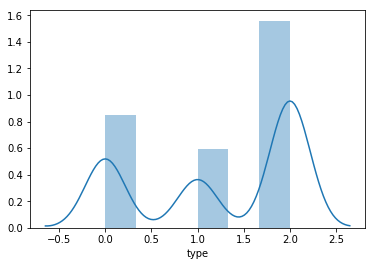

In [11]:
sns.distplot(fulldf['type'])
prind=len(indicadf)/len(fulldf)
prsat=len(sativadf)/len(fulldf)
prhyb=len(hybriddf)/len(fulldf)
print('Probability of Indica: {}'.format(prind))
print('Probability of Sativa: {}'.format(prsat))
print('Probability of Hybrid: {}'.format(prhyb))

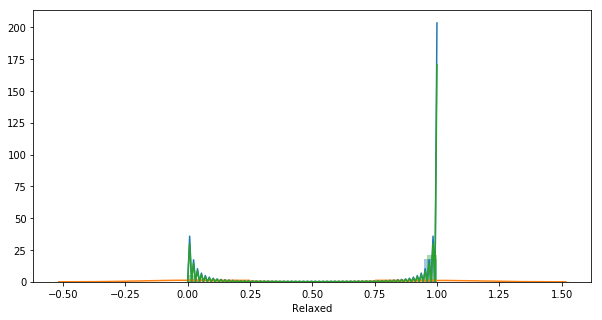

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(indicadf['Relaxed'])
sns.distplot(sativadf['Relaxed'])
sns.distplot(hybriddf['Relaxed'])

## Train Test Split

In [43]:
features=fulldf.drop(columns=['name','type'])
target=label_binarize(fulldf.type,classes=[0,1,2])
n_classes=target.shape[1]
                    
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

## Scale Features

In [44]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=features.columns)
scaled_df_train.head()

/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,Stress,Lack of Appetite,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,0.510598,-0.504547,0.398253,1.570991,1.074622,0.452414,1.097983,0.530183,0.313179,1.313342,...,-0.678965,-0.381730,-0.248708,-0.469446,-0.151129,-0.093888,0.431741,0.215132,-0.089232,0.491372
1,-1.958489,1.981976,0.398253,-0.636541,-0.930560,-2.210365,1.097983,-1.886139,0.313179,1.313342,...,-0.678965,-0.381730,-0.248708,-0.469446,-0.151129,-0.093888,-1.368636,-0.979400,-2.065765,1.498362
2,0.510598,-0.504547,-2.510969,-0.636541,-0.930560,-2.210365,-0.910761,0.530183,0.313179,1.313342,...,-0.678965,-0.381730,-0.248708,-0.469446,-0.151129,-0.093888,-1.368636,-1.576665,-2.065765,0.894168
3,0.510598,-0.504547,0.398253,-0.636541,-0.930560,0.452414,1.097983,-1.886139,0.313179,1.313342,...,-0.678965,-0.381730,-0.248708,-0.469446,-0.151129,-0.093888,-3.169014,-0.979400,0.899035,-0.112822
4,-1.958489,-0.504547,0.398253,-0.636541,-0.930560,0.452414,1.097983,0.530183,0.313179,-0.761416,...,-0.678965,2.619656,-0.248708,-0.469446,-0.151129,-0.093888,0.431741,-0.979400,-0.089232,-0.515618


## Scale all data

In [45]:
scaleddf= scaler.fit_transform(fulldf.drop(columns='name'))

scaleddf = pd.DataFrame(scaleddf, columns=fulldf.drop(columns='name').columns)
scaleddf.head()

/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,Stress,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,-1.432740,0.526262,1.985559,0.403034,1.579931,1.066236,-2.15201,1.109288,0.510441,0.328732,...,-0.674914,-0.375761,-0.248644,-0.470461,-0.138881,-0.089836,0.431911,0.218503,-0.079545,-4.241612
1,0.883242,-1.900194,-0.503636,0.403034,-0.632939,-0.937879,-2.15201,-0.901479,0.510441,0.328732,...,-0.674914,-0.375761,4.021816,-0.470461,-0.138881,-0.089836,0.431911,-0.975228,-0.079545,-4.241612
2,-1.432740,0.526262,-0.503636,0.403034,1.579931,1.066236,-2.15201,1.109288,-1.959089,-3.041995,...,-0.674914,-0.375761,-0.248644,-0.470461,-0.138881,-0.089836,-3.197727,-0.975228,-0.079545,-4.241612
3,0.883242,0.526262,-0.503636,0.403034,1.579931,-0.937879,-2.15201,-0.901479,-1.959089,-3.041995,...,-0.674914,-0.375761,-0.248644,-0.470461,-0.138881,-0.089836,0.431911,0.218503,-1.055387,-4.241612
4,-1.432740,-1.900194,1.985559,0.403034,-0.632939,-0.937879,-2.15201,-0.901479,-1.959089,0.328732,...,-0.674914,-0.375761,4.021816,-0.470461,-0.138881,-0.089836,0.431911,-0.378362,-1.055387,-4.241612


## Converting types

In [46]:
for i in fulldf['type']:
    i=int(i)
for i in fulldf['Relaxed']:
    i=int(i)
# fulldf['Relaxed']=int(fulldf['Relaxed'])

## Looking at differences in effects among classes

/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/_kernel_base.py:513: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a maske

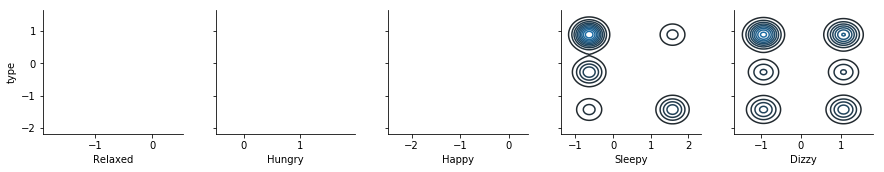

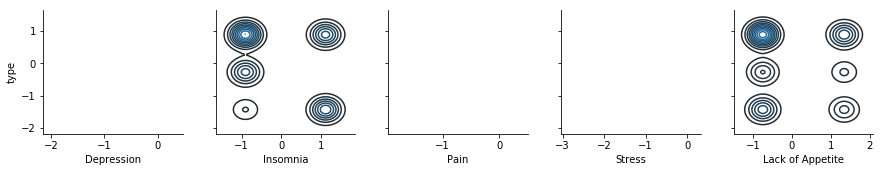

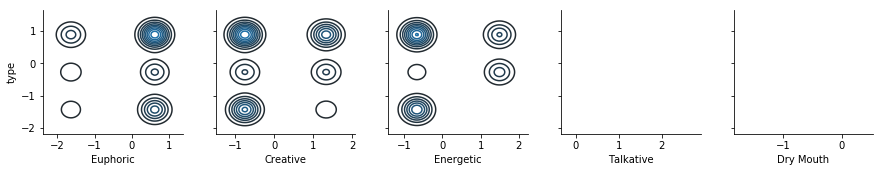

In [48]:
for i in range(0, 13, 5):
    g = sns.PairGrid(scaleddf,
                     x_vars = effects[i:i+5],
                     y_vars = ["type"])
    g = g.map(sns.kdeplot)

## Looking at distributions of each effect before and after scaling

/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


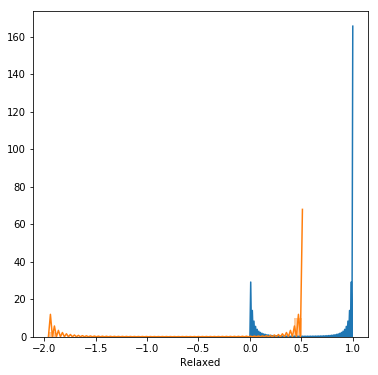

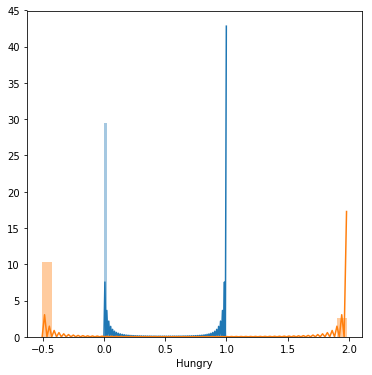

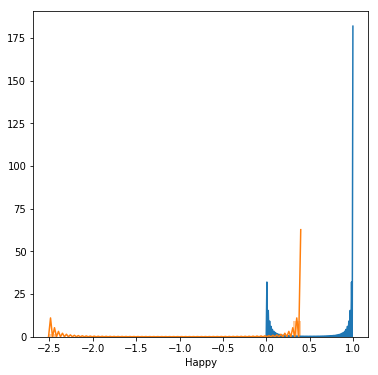

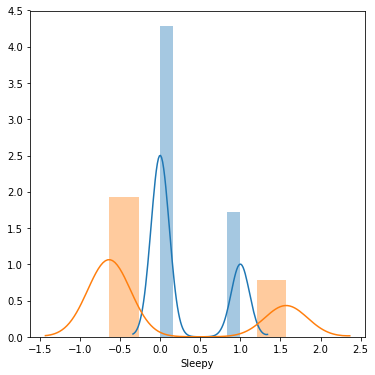

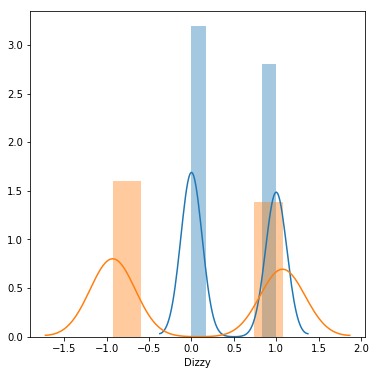

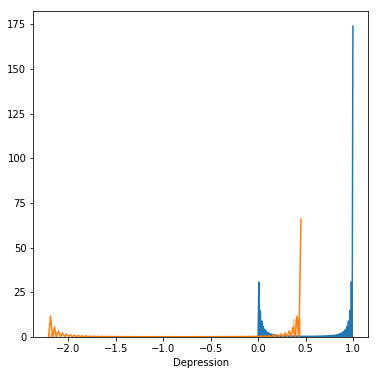

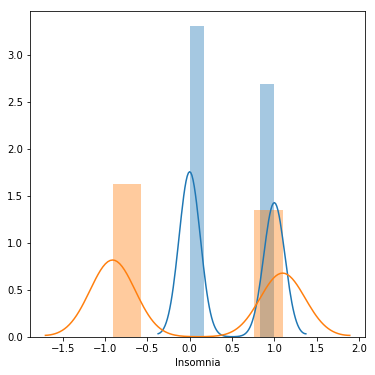

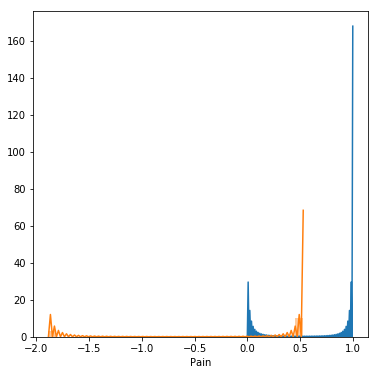

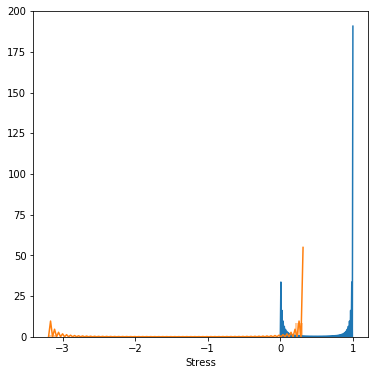

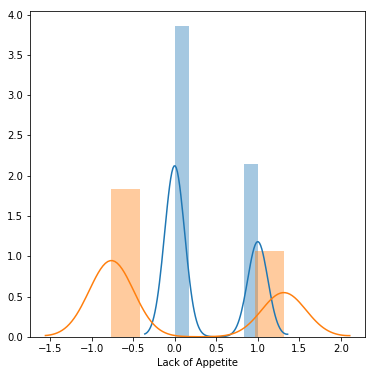

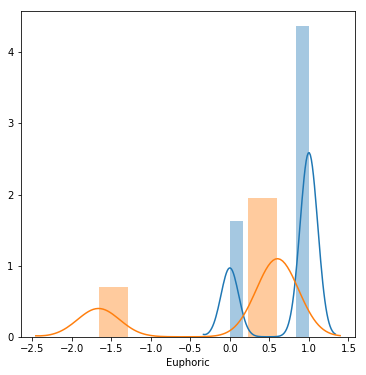

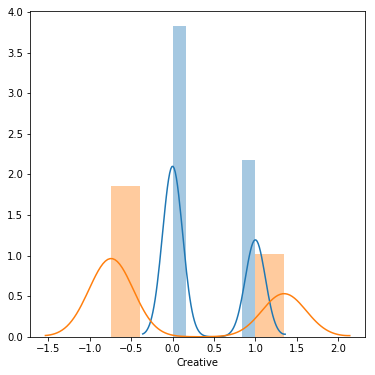

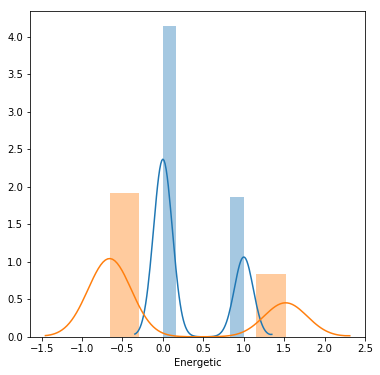

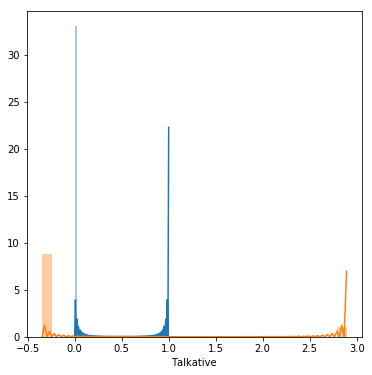

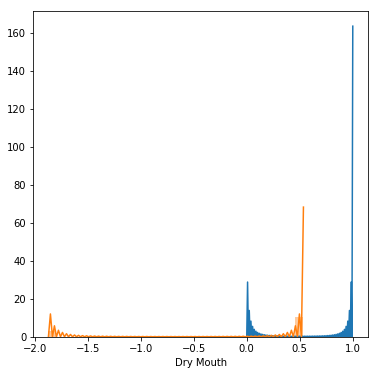

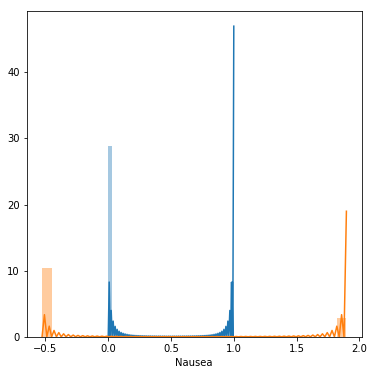

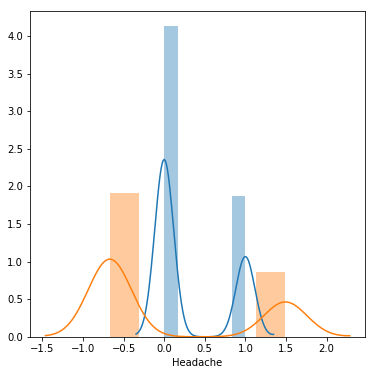

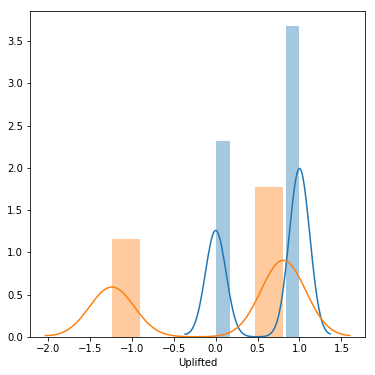

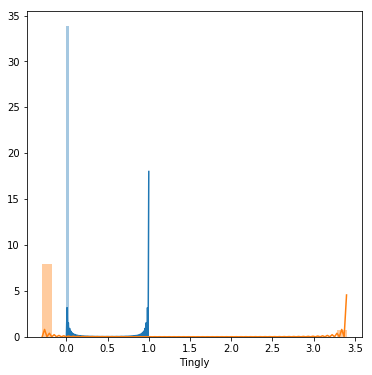

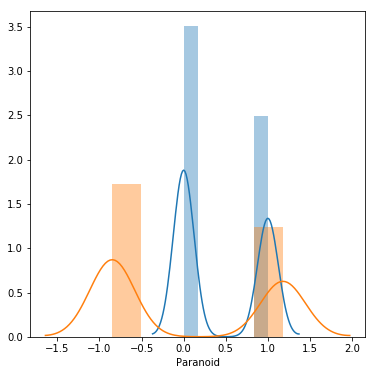

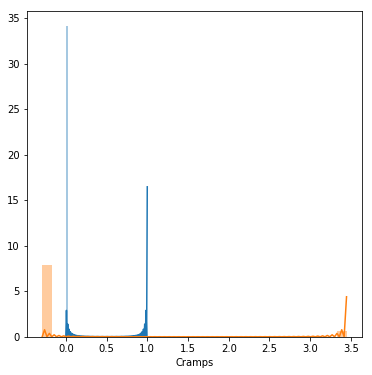

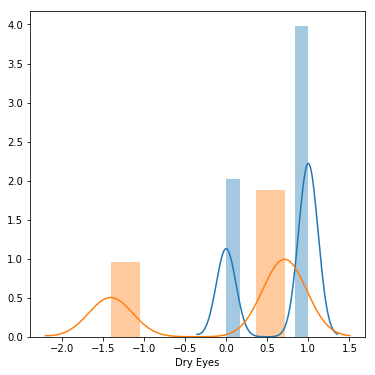

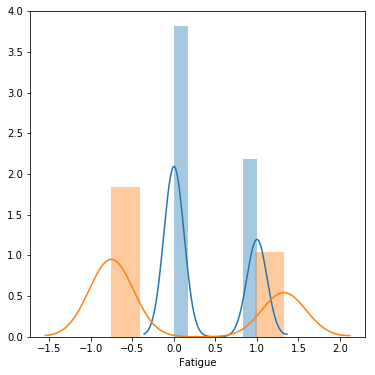

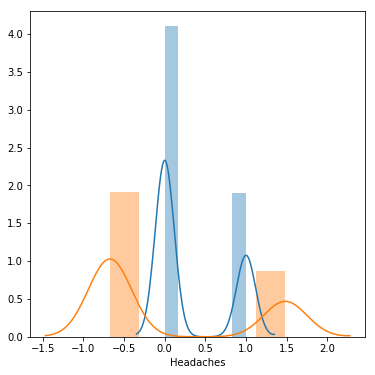

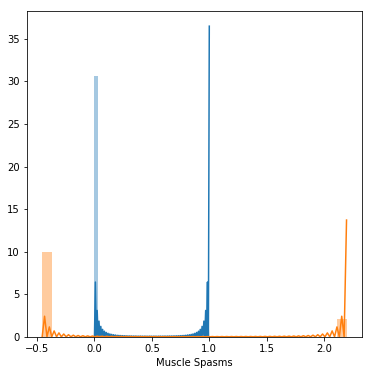

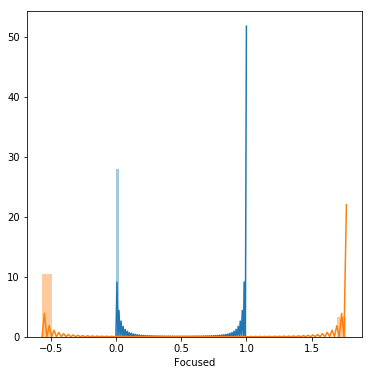

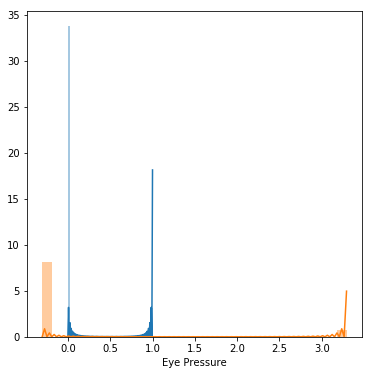

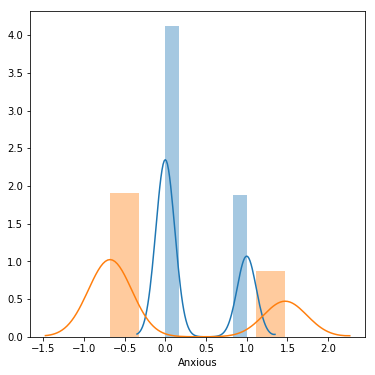

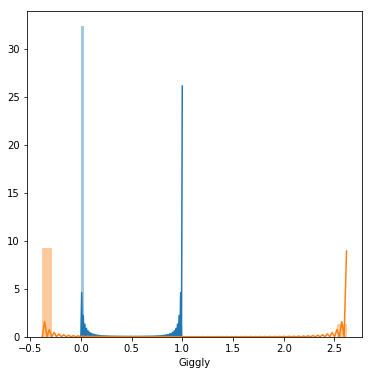

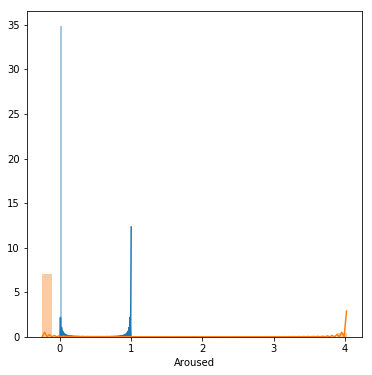

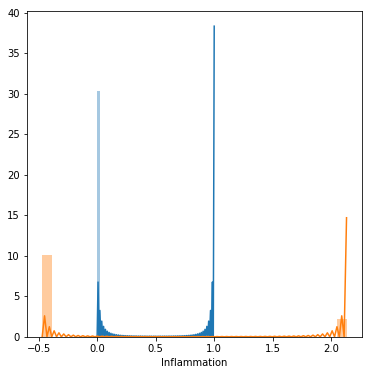

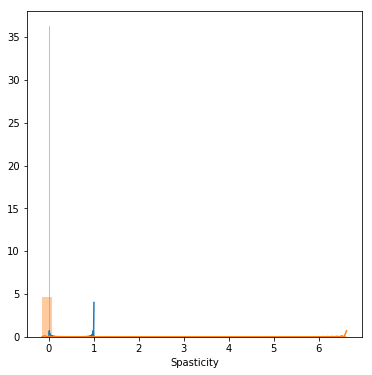

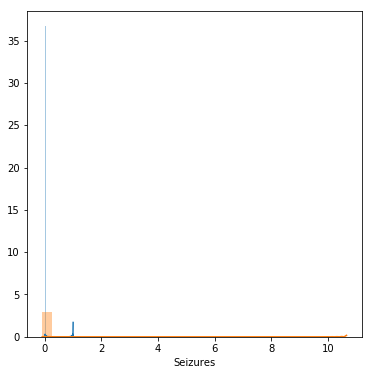

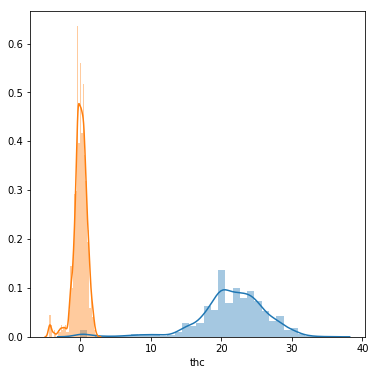

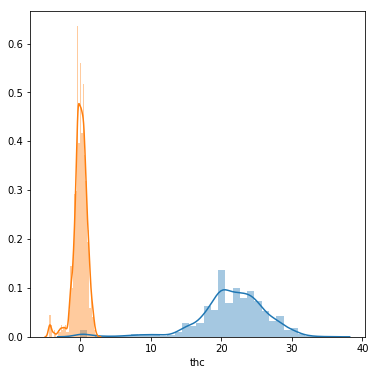

In [49]:
effects.append('thc')
for e in effects:
    plt.figure(figsize=(6,6))
    sns.distplot(fulldf[e])
    sns.distplot(scaled_df_train[e])

## Examining different kinds of effects v. thc content

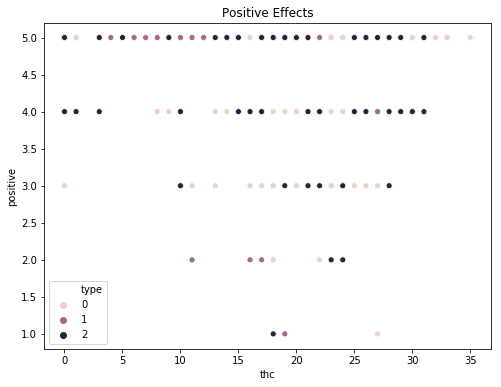

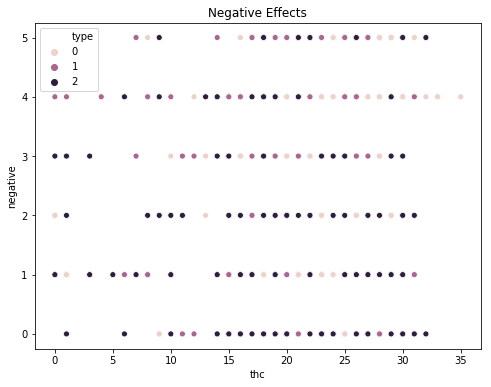

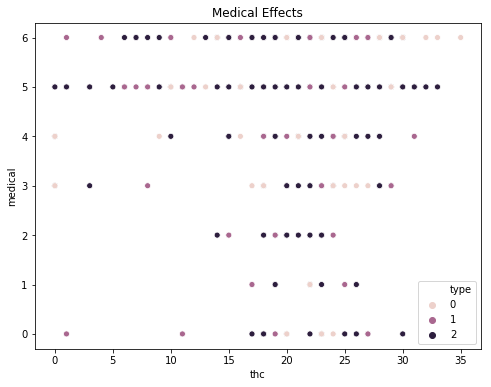

In [50]:
plt.figure(figsize=(8,6))
plt.title('Positive Effects')
sns.scatterplot(x='thc',y='positive',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Negative Effects')
sns.scatterplot(x='thc',y='negative',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Medical Effects')
sns.scatterplot(x='thc',y='medical',hue='type',data=fulldf)

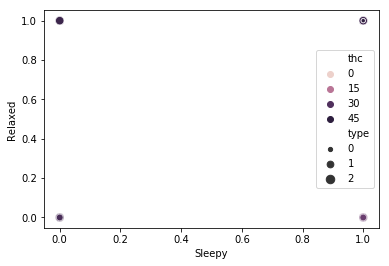

In [74]:
sns.scatterplot(x='Sleepy',y='Relaxed',hue='thc',alpha=0.8,size='type',data=fulldf)

# Beginning Modeling

## KNN Base Model

In [83]:
clf1 = KNeighborsClassifier()
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)

In [84]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds,average=None)))
    print("Recall Score: {}".format(recall_score(labels, preds,average=None)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds,average=None)))
    
print_metrics(y_test, test_preds)

Precision Score: [0.57608696 0.5        0.60989011]
Recall Score: [0.56382979 0.34285714 0.61666667]
Accuracy Score: 0.5465116279069767
F1 Score: [0.56989247 0.40677966 0.61325967]


## Getting best KNN model

In [53]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        if accuracy > best_score:
            best_k = k
            best_score = accuracy
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy: {}".format(best_score))

In [54]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 19
Accuracy: 0.5843023255813954


In [55]:
clf1 = KNeighborsClassifier(n_neighbors=21)
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)

Precision Score: [0.625      0.67857143 0.63076923]
Recall Score: [0.53191489 0.27142857 0.68333333]
Accuracy Score: 0.5581395348837209
F1 Score: [0.57471264 0.3877551  0.656     ]


## Decision Tree

In [56]:
classifier = DecisionTreeClassifier(random_state=10)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [57]:
y_pred = classifier.predict(X_test) 

In [67]:
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

# Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is: 56.68604651162791
Micro-averaged precision score: 0.57
Macro-averaged precision score: 0.56
Per-class precision score: [0.63829787 0.47142857 0.56666667]

Confusion Matrix
----------------


ValueError: If using all scalar values, you must pass an index

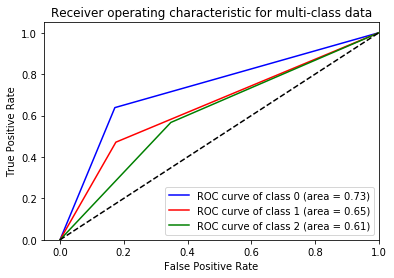

In [65]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score=classifier.fit(X_train, y_train).predict(X_test)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [75]:
classifier = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [76]:
y_pred = classifier.predict(X_test) 

In [78]:
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

# Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is: 54.94186046511628
Micro-averaged precision score: 0.55
Macro-averaged precision score: 0.55
Per-class precision score: [0.57446809 0.51428571 0.55      ]

Confusion Matrix
----------------


ValueError: If using all scalar values, you must pass an index

In [ ]:
#Still need to get F1, Recall, and Decision Tree visualization!!!

## Random Forest

### Regular Tree Baseline

In [88]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

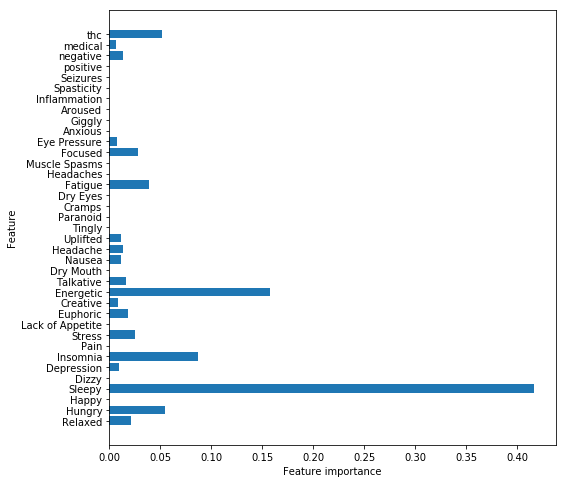

In [92]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree_clf)

In [97]:
#How to with multilabel-indicator????
# pred = tree_clf.predict(X_test)
# print(confusion_matrix(y_test, pred))
# print(classification_report(X_test, pred))

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

Accuracy is: 0.5494186046511628


### Forest

In [100]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [101]:
forest.score(X_train,y_train)

0.6446601941747573

In [102]:
forest.score(X_test,y_test)

0.5901162790697675

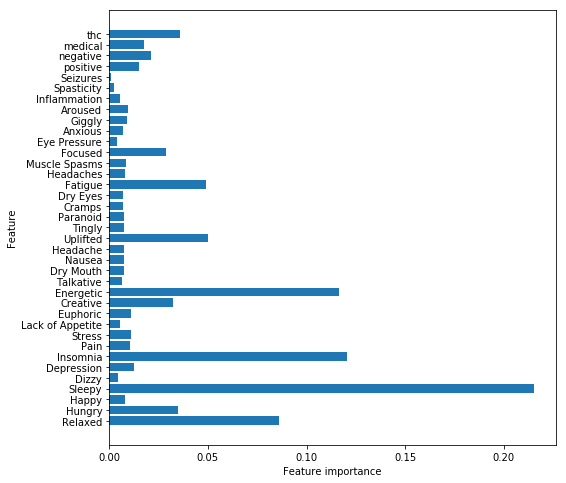

In [103]:
plot_feature_importances(forest)

In [105]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
print(forest_2.score(X_train,y_train))
print(forest_2.score(X_test,y_test))

0.5572815533980583
0.5436046511627907


## Grid Search

In [110]:
dt_clf=DecisionTreeClassifier()
dt_cv_score=cross_val_score(dt_clf, X_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

Mean Cross Validation Score: 52.92%


/Users/mackenziemitchell/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [111]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [112]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [114]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 67.3%
Mean Testing Score: 65.12%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2}